In [ ]:
#An attempt at using a siamese network to measure difference btween cars.  Will eventually develop
#into one-shot learning

In [4]:
from zipfile import ZipFile
with ZipFile('/content/images_test.zip','r') as zip01:
  zip01.extractall("/content/test")


In [5]:
from PIL import Image
import numpy as np
import sys
import os
import csv

#Useful function
def createFileList(myDir, format='.jpg'):
 fileList = []
 print(myDir)
 for root, dirs, files in os.walk(myDir, topdown=False):
    for name in files:
        if name.endswith(format):
            fullName = os.path.join(root, name)
            fileList.append(fullName)
 return fileList

# load the original image
myFileList = createFileList('/content/test')

for file in myFileList:
    print(file)
    img_file = Image.open(file)
    # img_file.show()

    # get original image parameters...
    width, height = img_file.size
    format = img_file.format
    mode = img_file.mode

    # Make image Greyscale
    img_grey = img_file.convert('L')
    #img_grey.save('result.png')
    #img_grey.show()

    # Save Greyscale values
    value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
    value = value.flatten()
    print(value)
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

/content/test
/content/test/images_test/images_test/bmw_3_e492d613f1864a89b56a491d424e4be0.jpg


<ipython-input-5-86a5b656a8a6>:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))


[209 209 209 ... 177 180 179]
/content/test/images_test/images_test/bmw_2.jpg
[ 14  17  17 ... 154 155 156]
/content/test/images_test/images_test/Alfa_Romeo_Stelvio_Suv_Free_Car_Picture_-_Give_Credit_Via_Link.(cropped).jpg
[155 155 155 ...  41  36  41]
/content/test/images_test/images_test/dacia_duster_6436fa68aaf342669b9ab82ca51d648e.jpg
[ 43  69  86 ... 112 112 111]
/content/test/images_test/images_test/2023-bmw-3-series-101-1652798461.jpg
[214 214 214 ... 178 177 176]
/content/test/images_test/images_test/dacia_duster_2e80fb0ff96f4316802e210c0b4b50ef.jpg
[255 255 255 ... 255 255 255]
/content/test/images_test/images_test/bmw_1.jpg
[166 166 166 ...  12  12  12]
/content/test/images_test/images_test/bmw_3_1fc2cf7fa0924272a2a62c0064b3afcf.jpg
[214 214 214 ... 178 177 176]


In [6]:
#import necessary libraries
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
%matplotlib inline

In [7]:
#set the path of training data
path_root="/content/test/images_test"

In [8]:
#list the classes
#class_names=pd.read_csv('/content/img_pixels.csv')
class_names=os.listdir(path_root)
class_names.sort()
print(class_names)

['images_test']


In [9]:
#loop to determine biggest/smallest picture in training set and total number of pictures
min_width=9999
min_height=9999
max_width=0
max_height=0
picture_count=0
picture_list=[]
aspect_ratio=[]
for i in class_names:
    path=os.path.join(path_root,i)
    pictures=os.listdir(path)
    pictures.sort()
    for j in pictures:
        img=cv2.imread(os.path.join(path,j),0)
        min_width=min(min_width,np.shape(img)[1])
        min_height=min(min_height,np.shape(img)[0])
        max_width=max(max_width,np.shape(img)[1])
        max_height=max(max_height,np.shape(img)[0])
        picture_count=picture_count+1
        aspect_ratio.append(np.shape(img)[1]/np.shape(img)[0])

The pictures in the dataset are all different sizes.  I tried a few different strategies, but settled on resizing to a small image at the most common aspect ratio.

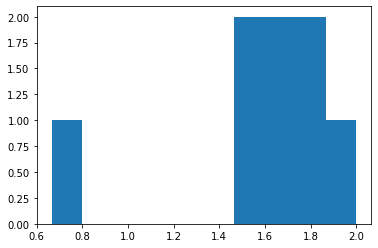

In [10]:
plt.hist(aspect_ratio)
plt.show()

In [11]:
#most common aspect ratio.  I used 135x100px for the input image size
np.median(aspect_ratio)

1.6821548821548822

In [12]:
print([min_width,min_height,max_width,max_height,picture_count])

[548, 330, 2048, 1500, 8]


In [13]:
resize_width=135
resize_height=100
print([resize_width,resize_height])

[135, 100]


Generator for image data.  Returns tensor consisting of two image columns and a label column.  For the first half of each batch the two images are of the same class of car (year make model) and the label is 1.  For the second half of the batch the two images are different classes and the label is 0.  Images are also resized when the generator is called

In [14]:
def pair_generator(batch_size,training=True):
    good_pairs=math.ceil(batch_size/2)
    bad_pairs=batch_size-good_pairs
    left_pictures=[]
    right_pictures=[]
    labels=[]
    #if training:
    path_root=("/content/test/images_test")
    class_names=os.listdir(path_root)
    #else:
        #path_root=('/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test')
       # class_names=os.listdir(path_root)
    while True:
        pair_classes=random.choices(class_names,k=batch_size)
        for i in range(batch_size):
            if i<good_pairs:
                pics=random.sample(os.listdir(os.path.join(path_root,pair_classes[i])),k=2)
                img=cv2.imread(os.path.join(path_root,pair_classes[i],pics[0]))
                img[0]=img[0]/255
                img[1]=img[1]/255
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(resize_width,resize_height))
                left_pictures.append(img)
                img=cv2.imread(os.path.join(path_root,pair_classes[i],pics[1]))
                img[0]=img[0]/255
                img[1]=img[1]/255
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(resize_width,resize_height))
                right_pictures.append(img)
                labels.append(1)
            else:
                classes=random.sample(pair_classes,k=2)
                pic1=random.sample(os.listdir(os.path.join(path_root,classes[0])),k=1)
                img=cv2.imread(os.path.join(path_root,classes[0],pic1[0]))
                img[0]=img[0]/255
                img[1]=img[1]/255
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(resize_width,resize_height))
                left_pictures.append(img)
                pic2=random.sample(os.listdir(os.path.join(path_root,classes[1])),k=1)
                img=cv2.imread(os.path.join(path_root,classes[1],pic2[0]))
                img[0]=img[0]/255
                img[1]=img[1]/255
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(resize_width,resize_height))
                right_pictures.append(img)
                labels.append(0)
        left_pictures=np.asarray(left_pictures)
        right_pictures=np.asarray(right_pictures)
        labels=np.asarray(labels)
        out=([left_pictures,right_pictures],labels)
        yield out
        left_pictures=[]
        right_pictures=[]
        labels=[]
        

In [15]:
#get 10 pairs to demonstrate the generator
batch_size=10
foo=pair_generator(batch_size)
bar=next(foo)

In [16]:
#verify the shape of the output tensor.  [0][0] is the left image
#expect 10 pairs, 100x135px images, 3 color channels
np.shape(bar[0][0])

(10, 100, 135, 3)

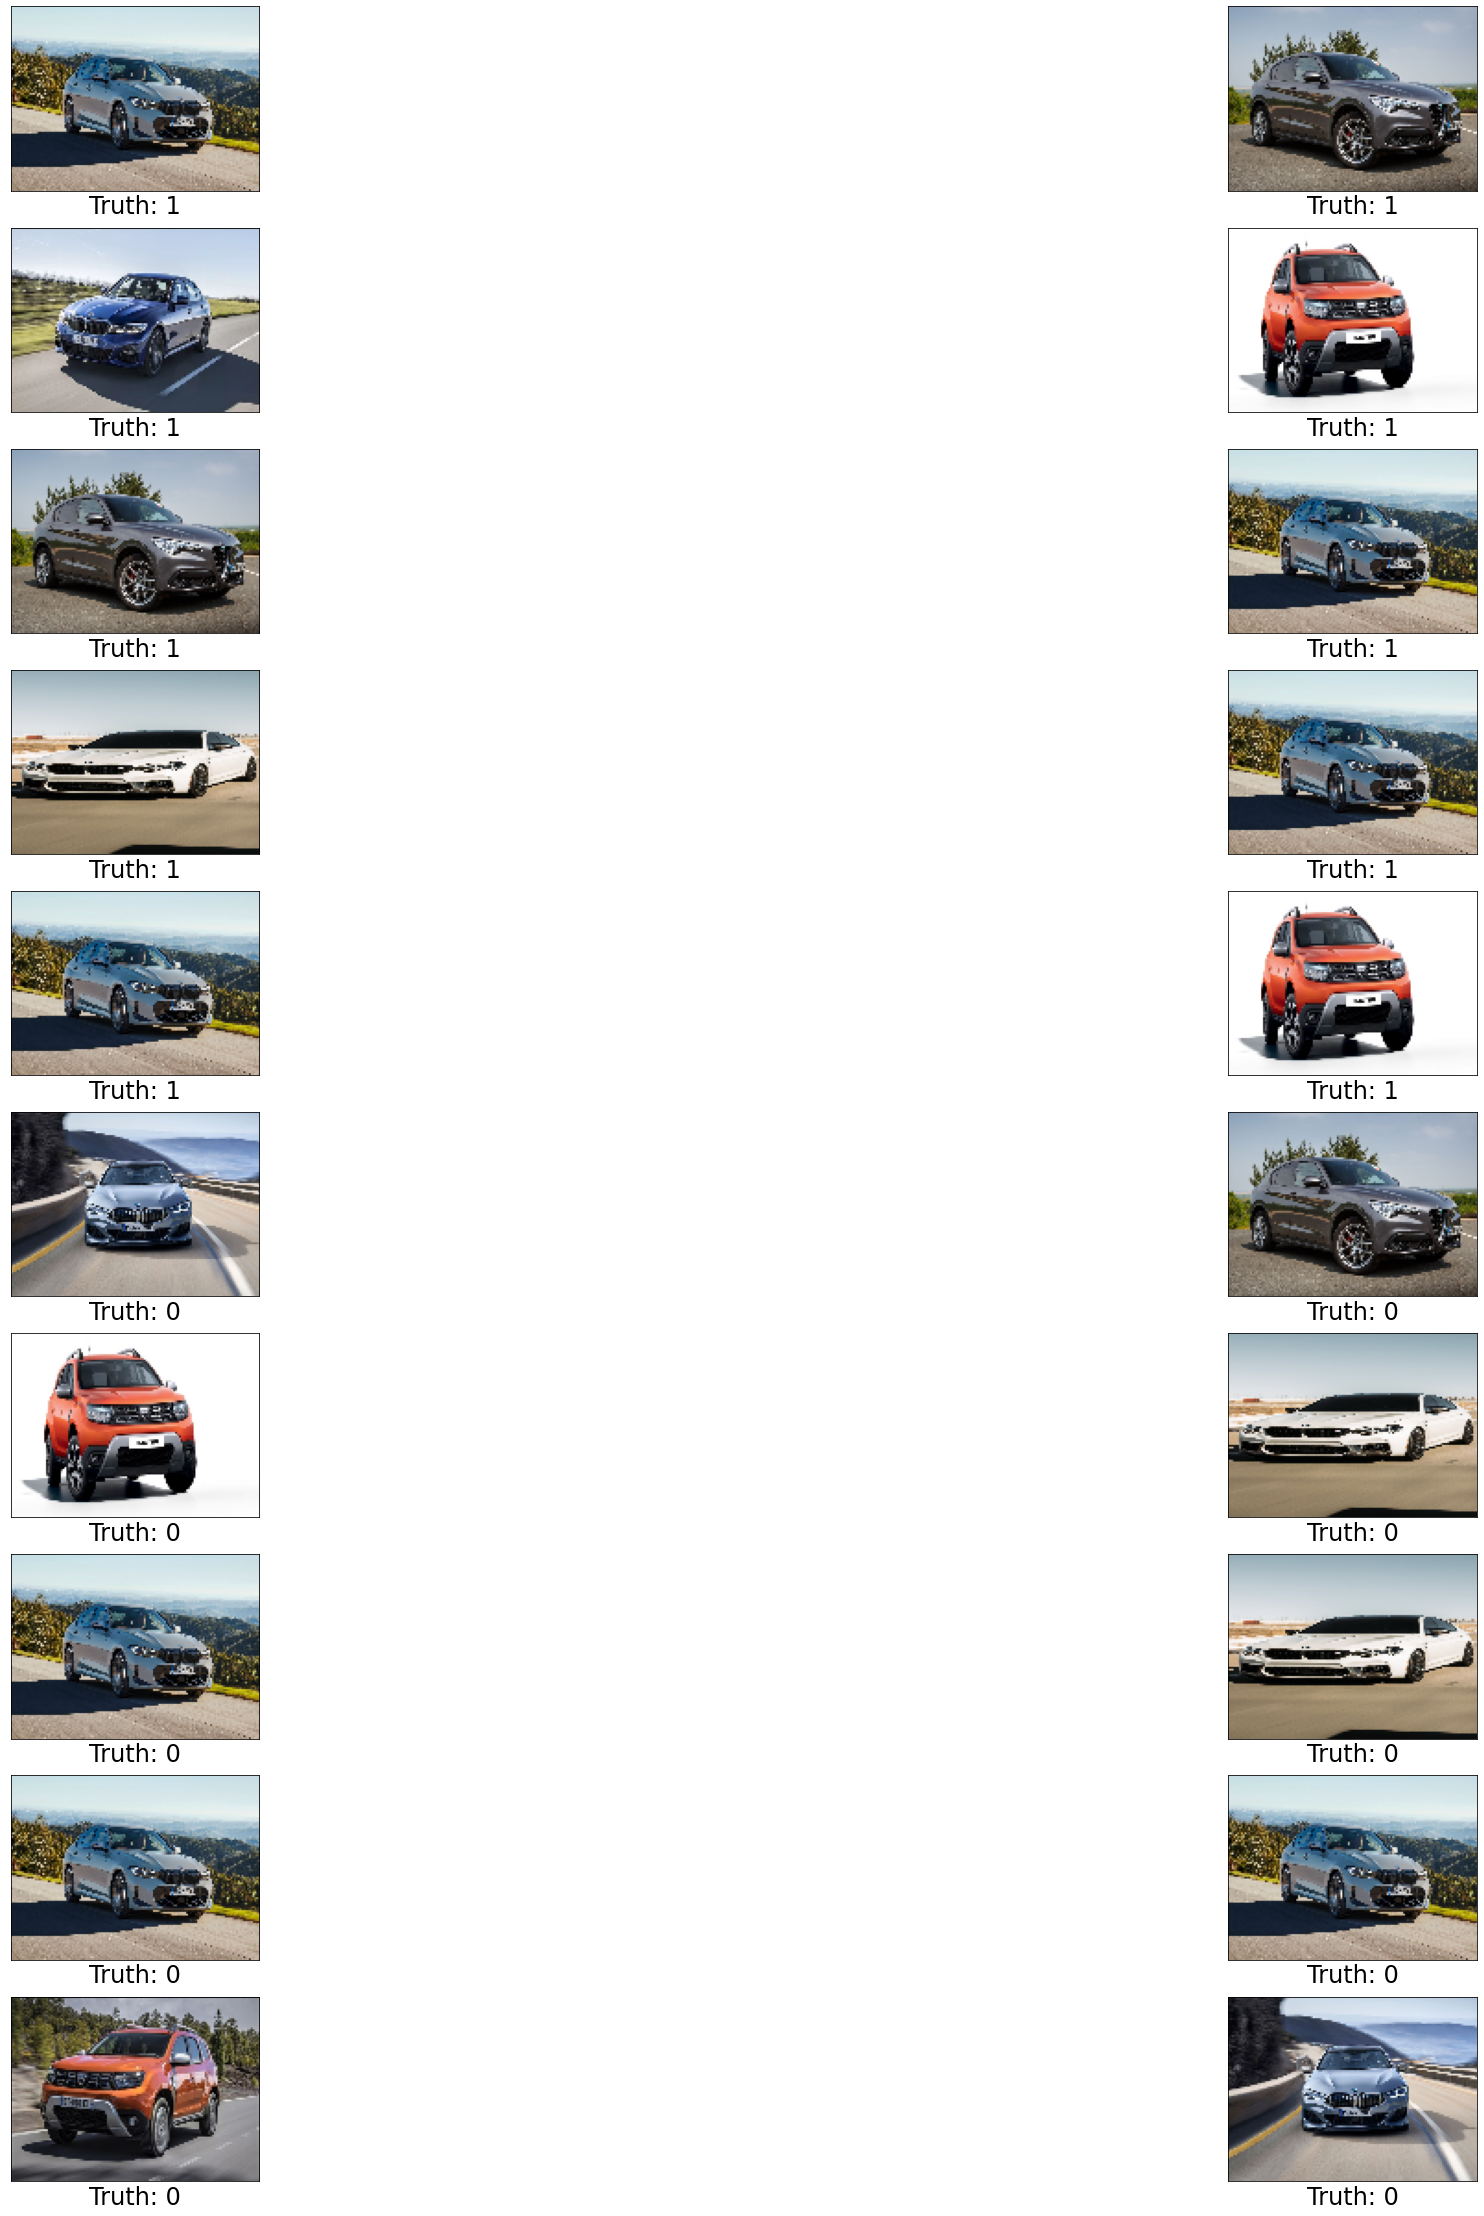

In [17]:
#plot the pairs to demonstrate output
count=1
plt.figure(figsize=(40,40))
for i in range(batch_size):
    for j in range(2):
        plt.subplot(batch_size,2,count)
        plt.imshow(bar[0][j][i])
        count=count+1
        plt.xlabel('Truth: '+str(bar[1][i]),fontsize=24)
        plt.xticks([])
        plt.yticks([])
plt.show()

Define a siamese model.  The sequential model is used by both sides of the net.  The L1 layer is a simple absoulte value of the difference between the two tensors.

In [18]:
def make_model():
    shape=(100,135,3)
    left_input=keras.Input(shape)
    right_input=keras.Input(shape)
    model=keras.Sequential()
    model.add(keras.layers.Conv2D(32,8,activation='relu',padding='same',input_shape=shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(padding='same'))
    model.add(keras.layers.Conv2D(64,4,activation='relu',padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(padding='same'))
    model.add(keras.layers.Conv2D(128,4,activation='relu',padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(padding='same'))
    model.add(keras.layers.Conv2D(256,4,activation='relu',padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2048,activation='relu'))
    encoded_l=model(left_input)
    encoded_r=model(right_input)
    L1_layer = keras.layers.Lambda(lambda tensors:tf.math.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = keras.layers.Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = keras.Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net
    

In [19]:
model=make_model()

In [20]:
model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['Accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 135, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 135, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 2048)         33728864    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [22]:
prayers=pair_generator(128)

In [25]:
#train the model.  128 batch size times 64 setps is approximately the entire training set.
#100 Epochs is around 4 hours of training.  Note the CPU load from resizing the images
#in the pair generator is by far the limiting factor
model.fit(prayers,epochs=25,steps_per_epoch=20,verbose=1)

Epoch 1/25
20/20 [==============================] - 565s 28s/step - loss: 1.3782 - Accuracy: 0.5125
Epoch 2/25
20/20 [==============================] - 562s 28s/step - loss: 1.0061 - Accuracy: 0.5020
Epoch 3/25
20/20 [==============================] - 560s 28s/step - loss: 1.0343 - Accuracy: 0.5336
Epoch 4/25
20/20 [==============================] - 554s 28s/step - loss: 0.9240 - Accuracy: 0.5219
Epoch 5/25
20/20 [==============================] - 556s 28s/step - loss: 0.8907 - Accuracy: 0.5199
Epoch 6/25
20/20 [==============================] - 568s 28s/step - loss: 0.8875 - Accuracy: 0.5281
Epoch 7/25
20/20 [==============================] - 564s 28s/step - loss: 0.8602 - Accuracy: 0.5184
Epoch 8/25
20/20 [==============================] - 559s 28s/step - loss: 0.8459 - Accuracy: 0.5430
Epoch 9/25
20/20 [==============================] - 585s 29s/step - loss: 0.7923 - Accuracy: 0.5273
Epoch 10/25
20/20 [==============================] - 581s 29s/step - loss: 0.7656 - Accuracy: 0.5297

In [26]:
#generate a batch to compare the prediction to actual labels visually
batch_size=10
results=pair_generator(batch_size,training=False)
test_data=next(results)
test_x=test_data[0]
test_y=test_data[1]
out=model.predict(test_x,steps=1,verbose=1)

1/1 [==============================] - 2s 2s/step


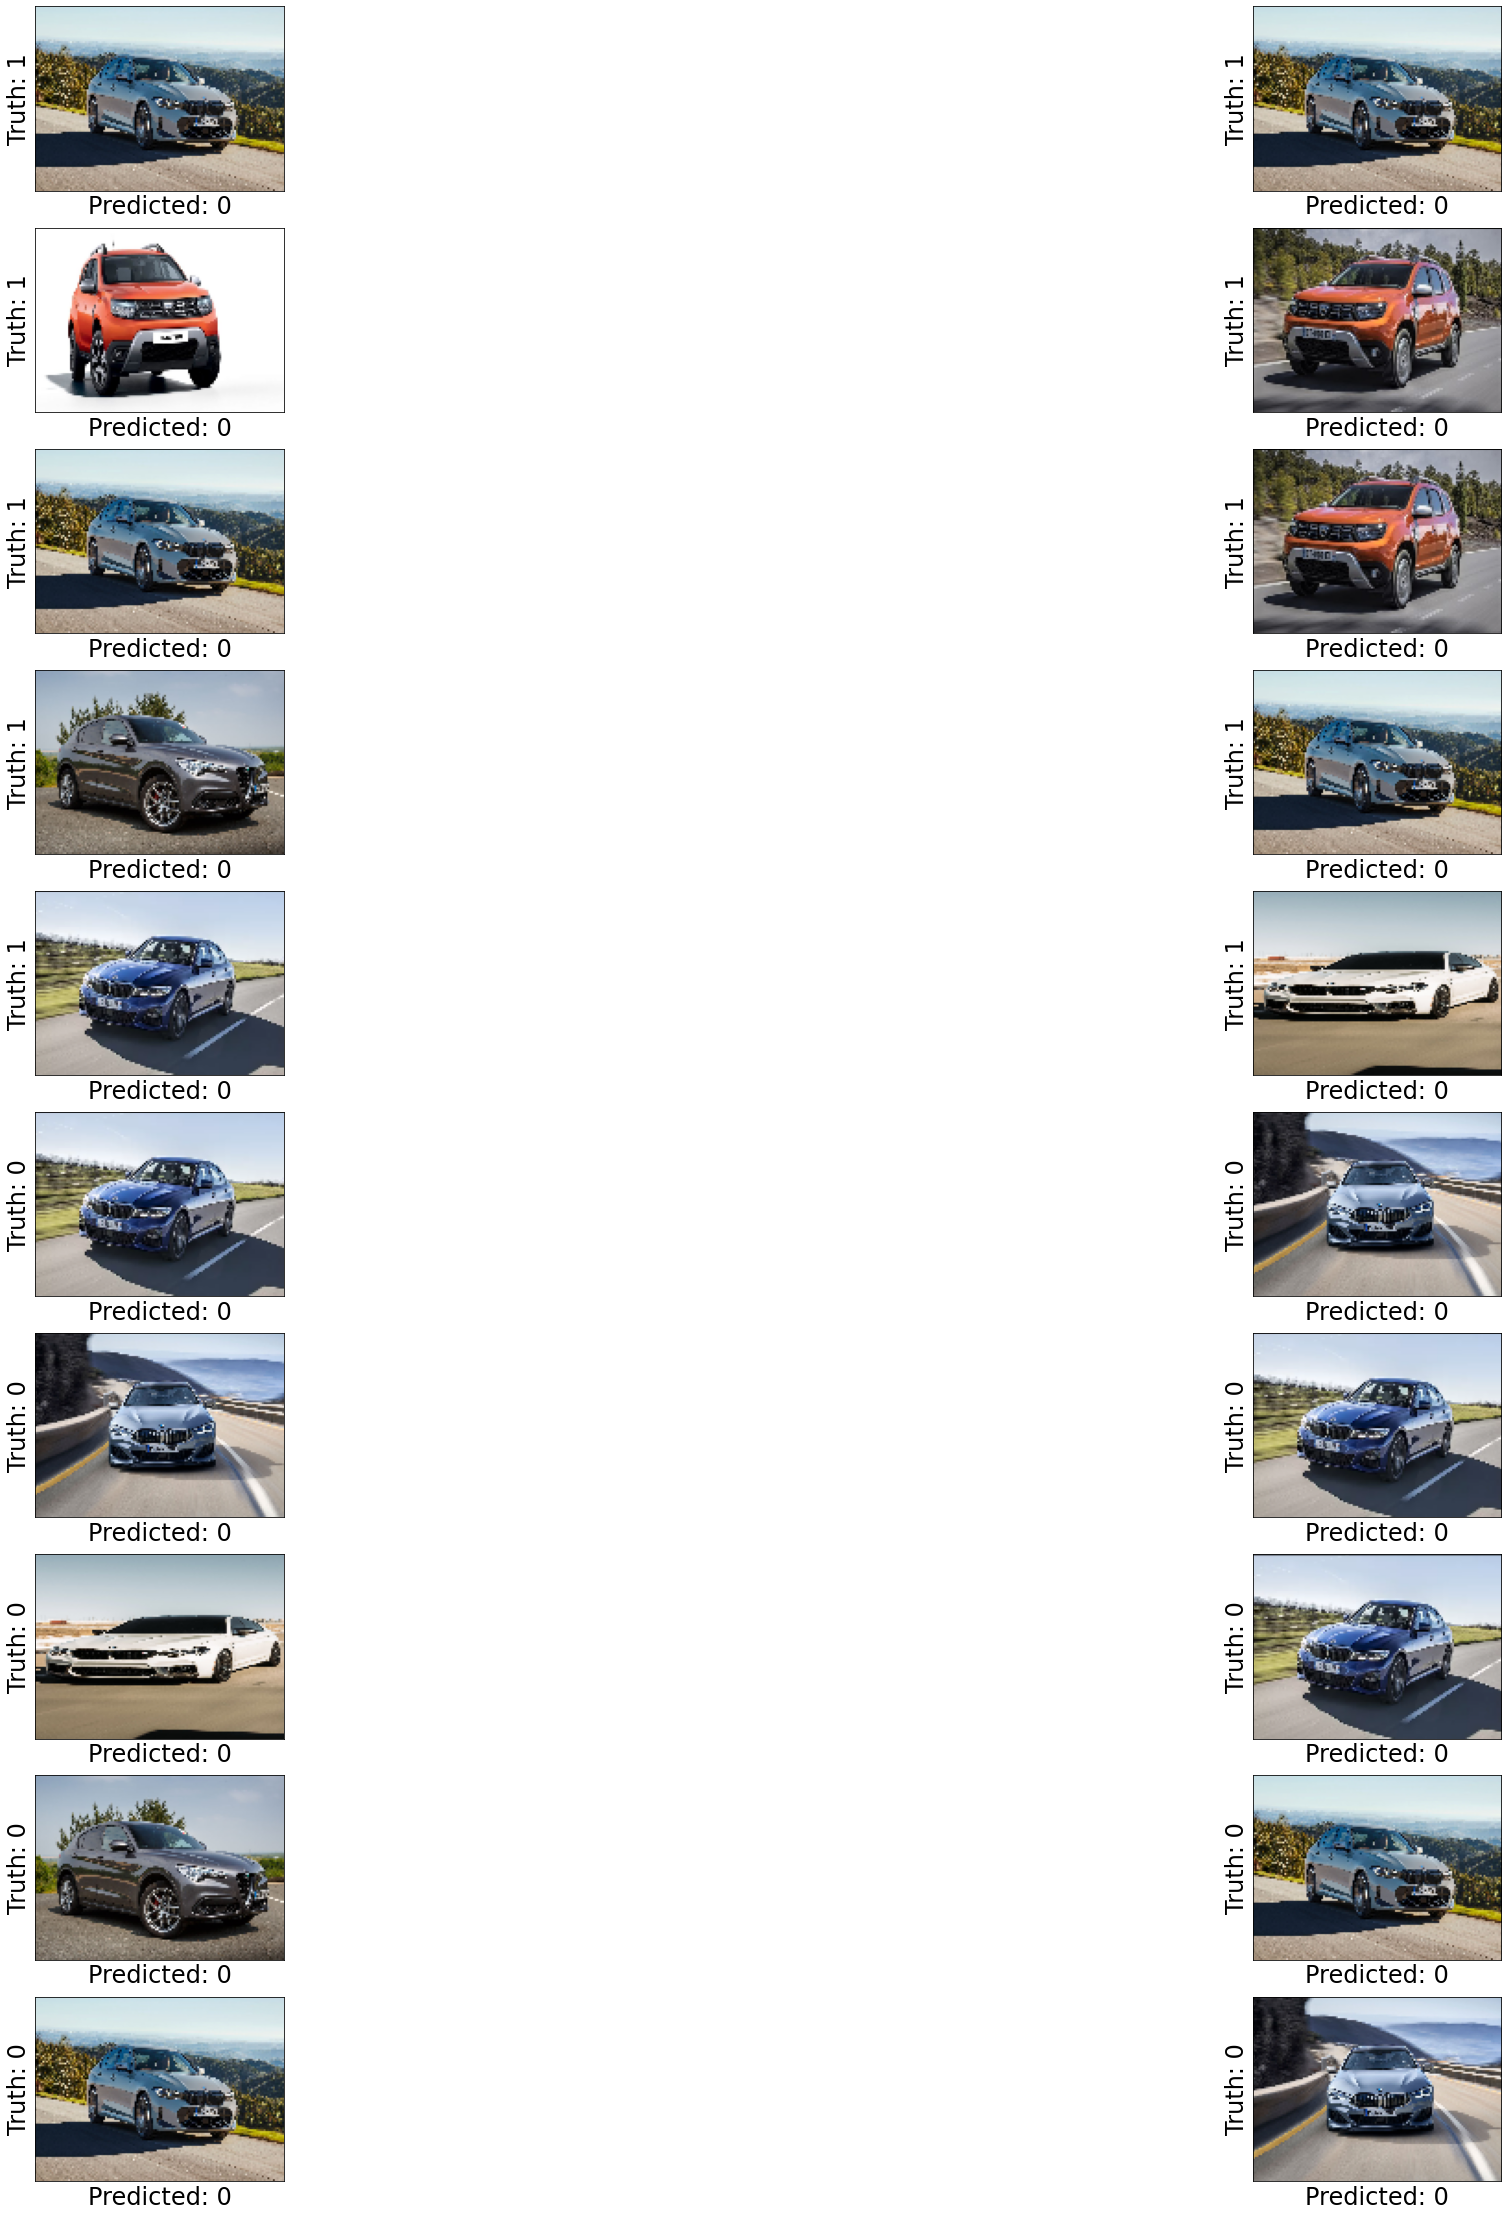

In [27]:
count=1
plt.figure(figsize=(40,40))
for i in range(batch_size):
    for j in range(2):
        plt.subplot(batch_size,2,count)
        plt.imshow(test_x[j][i])
        count=count+1
        plt.ylabel('Truth: '+str(test_y[i]),fontsize=24)
        plt.xlabel('Predicted: '+str(int(out[i][0])),fontsize=24)
        plt.xticks([])
        plt.yticks([])
plt.show()

In [29]:
path_root=("/content/test/images_test")
class_names=os.listdir(path_root)

In [30]:
#find the number of pictures in the test set
picture_count=0
for i in class_names:
    path=os.path.join(path_root,i)
    pictures=os.listdir(path)
    pictures.sort()
    for j in pictures:
        picture_count=picture_count+1
print(picture_count)

8


In [31]:
#generate arrays of true and predicted values for the entire test set
i=0
final_predicted_y=[]
final_true_y=[]
while i<picture_count:
    results=pair_generator(128,training=False)
    test_data=next(results)
    test_x=test_data[0]
    test_y=test_data[1]
    out=model.predict(test_x,steps=1,verbose=0)
    out=np.reshape(out,128)
    final_predicted_y.append(out)
    final_true_y.append(test_y)
    i=i+128
final_predicted_y=np.asarray(final_predicted_y)
final_predicted_y=np.reshape(final_predicted_y,(-1,1))
final_true_y=np.asarray(final_true_y)
final_true_y=np.reshape(final_true_y,(-1,1))

In [32]:
#confusion matrix of results
foo=confusion_matrix(final_true_y,np.round(final_predicted_y))
print(foo)

[[54 10]
 [50 14]]
